# 2. Data Preprocessing

### Table of Contents
- [Importing Packages](#Importing-Packages)
- [Loading the Dataset](#Loading-the-Dataset)
- [Data Cleaning:](#Data-Cleaning)
  - [Handling Missing Values](#Handling-Missing-Values)
  - [Removing Duplicates](#Duplication-Removal)
  - [Detecting and Treating Outliers Using LOF](#Detecting-and-Treating-Outliers-using-LOF)
- [Creating Features](#Feature-Creation)
- [Encoding Data](#Encoding-Data)
- [Reducing Features Based on:](#Dimensionality-Reduction)
  - [Correlation Analysis](#Feature-Reduction-based-on-Correation-Analysis)
  - [Principal Component Analysis (PCA)](#Principal-Component-Analysis(PCA))
- [Splitting Data into Features and Target](#Splitting-Data-into-Features-and-Target)
- [Splitting Dataset into Training and Test Sets](#Splitting-Dataset-into-Training-and-Test-Sets)
- [Balancing Training Data Using SMOTE](#Balancing-Training-Data-using-SMOTE)

###  Navigation
- [Table of Contents](../Table_of_contents.ipynb)
- [Data Preparation and Exploration](../Data_exploration/Data_Exploration.ipynb)
- [Data Preprocessing](#2.-Data-Preprocessing)
- [Model Development](../conf/list_of_models.ipynb)
- [Model Selection and Performance Evaluation](../conf/list_of_performance_evaluations.ipynb)

#### Importing Packages

In [3]:
import os  # Import the OS module for operating system dependent functionality
import numpy as np  # package for numerical analysis
import pandas as pd  # package for data manipulation and analysis
from matplotlib import pyplot as plt  # pyplot module for plotting
import seaborn as sns  # package for statistical data visualization
from sklearn.model_selection import train_test_split #package for splitting tranind and testing sets
from sklearn.preprocessing import StandardScaler #package for feature scaling
from sklearn.decomposition import PCA # packge for for Principal Component Analysis
from sklearn.neighbors import LocalOutlierFactor # packages  for outlier detection
from imblearn.over_sampling import SMOTE  # SMOTE packege from imbalanced-learn for balancing the dataset

##### Load the Dataset

 Load dataset into a df dataframe
 - The path to the dataset is specified by `data_path`
 - `pd.read_csv` reads CSV formated dataset into a Pandas(pd) dataframe

In [37]:
#path to the dataset directory in the project
data_path = '../dataset/RT_IOT2022'
df = pd.read_csv(data_path, na_values="?")

### Data Cleaning

###### Handling Missing Values

In [38]:
#cheking missing value
missing_value_count = df.isnull() .sum()
if missing_value_count.any():
    print("colum missing value: " + missing_value_countng )    
else:
    print("No Missing value found")
    
#checking is NA value is available, because NA is not usefull in the model formation. it is better if we handle NA as missing value   
NA_value_count = df.isna().sum()
if NA_value_count.any():
    print("Data contains Null: " + NA_value_countng )    
else:
    print("Data is Clean of NA.")           
print("Data Shape:", df.shape)


No Missing value found
Data is Clean of NA.
Data Shape: (123117, 85)


#### Duplication Removal

In [39]:
# Removing duplicated rows from dataframe df
df.drop_duplicates(inplace=True)
print("DataFrame after removing duplicates:", df.shape)

DataFrame after removing duplicates: (123117, 85)


##### Detecting and Treating Outliers using LOF

LOF relies on distance calculations, which means it doesn't directly apply to categorical attributes. Therefore, I drop the categorical attributes before applying LOF. Additionally, the LOF threshold is adjusted by tuning the percentile and Z-score thresholds (calculated using standard deviation from the mean). This helps control the sensitivity of outlier detection.

In [40]:
#droping categorical features to apply LOF 
df_cleaned = df.drop(columns=['proto', 'service', 'Attack_type'])

#Apply LOF (Local Outlier Factor)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_scores = lof.fit_predict(df_cleaned)
lof_scores = -lof.negative_outlier_factor_

# appending LOF scores to the original data for reference
df['LOF_score'] = lof_scores

# calculating thresholds using both percentile based and Z-score
# Percentile-based threshold
percentile_threshold = np.percentile(df['LOF_score'], 99)
print(f"99th percentile threshold: {percentile_threshold}")

# Z-score threshold
mean_lof = df['LOF_score'].mean()
std_lof = df['LOF_score'].std()
z_score_threshold = mean_lof + 0.5 * std_lof
print(f"Z-score threshold (0.5 std deviations): {z_score_threshold}")

# Choose the lower of the two thresholds for a conservative approach
final_threshold = min(percentile_threshold, z_score_threshold)
print(f"Final chosen threshold: {final_threshold}")

# Identifying outliers based on the final threshold
df['Outlier'] = df['LOF_score'] > final_threshold

# Filter out the outliers
df_outlier_free = df[~df['Outlier']].drop(columns=['LOF_score', 'Outlier'])

# Print and save the results
outliers = df[df['Outlier']]
print("Number of outliers detected:", outliers.shape[0])
#print("\nOutliers detected:\n", outliers)

99th percentile threshold: 3.790419692288382
Z-score threshold (0.5 std deviations): 3.5579150656150347
Final chosen threshold: 3.5579150656150347
Number of outliers detected: 1337


In [41]:
df = df_outlier_free
df

,Unnamed: 0,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,...,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502,MQTT_Publish
1,1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,...,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502,MQTT_Publish
2,2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,...,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502,MQTT_Publish
3,3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,...,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502,MQTT_Publish
4,4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,...,0.0,2.981470e+07,2.981470e+07,2.981470e+07,2.981470e+07,0.0,64240,26847,502,MQTT_Publish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123112,2005,59247,63331,tcp,-,0.000006,1,1,0,0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1024,0,1024,NMAP_XMAS_TREE_SCAN
123113,2006,59247,64623,tcp,-,0.000007,1,1,0,0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1024,0,1024,NMAP_XMAS_TREE_SCAN
123114,2007,59247,64680,tcp,-,0.000006,1,1,0,0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1024,0,1024,NMAP_XMAS_TREE_SCAN
123115,2008,59247,65000,tcp,-,0.000006,1,1,0,0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1024,0,1024,NMAP_XMAS_TREE_SCAN


### Feature Creation

In [1]:
# Creating pattern type feature, that contains normal and attack patterns
normal_patterns = [
    'MQTT_Publish',  
    'Thing_Speak',
    'Wipro_bulb'
]

attack_patterns = [
    'ARP_poisioning',  
    'DDOS_Slowloris',
    'DOS_SYN_Hping',
    'Metasploit_Brute_Force_SSH',
    'NMAP_FIN_SCAN',
    'NMAP_OS_DETECTION',
    'NMAP_TCP_scan',
    'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN'
]
# Categorize each record
df['Pattern_Type'] = df['Attack_type'].apply(lambda x: 'Normal' if x in normal_patterns else 'Attack')

NameError: name 'df' is not defined

### Data Encoding

first find all the unique value of all the object type attributes

In [43]:
df['Attack_type'].unique()# list of unique values in 'Attack_type' column

array(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'ARP_poisioning',
       'DDOS_Slowloris', 'DOS_SYN_Hping', 'Metasploit_Brute_Force_SSH',
       'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
       'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN'], dtype=object)

In [44]:
df['service'].unique()# list of unique values in 'Service' column

array(['mqtt', '-', 'http', 'dns', 'ntp', 'ssl', 'dhcp', 'irc', 'ssh',
       'radius'], dtype=object)

In [45]:
df['proto'].unique()# list of unique values in 'Protocol' column

array(['tcp', 'udp', 'icmp'], dtype=object)

In [46]:
df['Pattern_Type'].unique()# list of unique values in 'Pattern_Type' column

array(['Normal', 'Attack'], dtype=object)

Encoding all the object type attribute to integers, so they are readable by the model for parameter training.  

I used predefined dictionaries for encoding.

###### mapping "Attack_Type" attribute to integers

In [47]:
dic = {'MQTT_Publish':1,'Thing_Speak':2,'Wipro_bulb':3,'ARP_poisioning':4,'DDOS_Slowloris':5,'DOS_SYN_Hping':6,'Metasploit_Brute_Force_SSH':7,'NMAP_FIN_SCAN':8,'NMAP_OS_DETECTION':9,'NMAP_TCP_scan':10,'NMAP_UDP_SCAN':11,'NMAP_XMAS_TREE_SCAN':12}
df['Attack_type'] = df['Attack_type'].map(dic)

In [48]:
df['Attack_type'].value_counts()# Ocurrences of each unique value in 'Attack_type' column

Attack_type
6     93886
2      7999
4      7520
1      4092
11     2570
12     1995
9      1987
10      990
5       482
3       204
7        36
8        19
Name: count, dtype: int64

###### mapping "service" column to integers

In [49]:
dic={'mqtt':1,'-':0,'http':2,'dns':3,'ntp':4,'ssl':5,'dhcp':6,'irc':7,'ssh':8,'radius':9}
df['service']=df['service'].map(dic)

In [50]:
df['service'].value_counts()# Ocurrences of each unique value in 'service' column

service
0    101890
3      9693
1      4081
2      3358
5      2533
4       117
6        40
7        38
8        28
9         2
Name: count, dtype: int64

###### mapping "protocol" column to integers

In [51]:
dic = {'tcp':0,'udp':1,'icmp':2}
df['proto'] = df['proto'].map(dic)

In [52]:
df['proto'].value_counts()# Ocurrences of each unique value in 'proto' column

proto
0    109253
1     12486
2        41
Name: count, dtype: int64

###### mapping "Pattern_type" column to integers

In [53]:
dic = {'Normal':0,'Attack':1}
df['Pattern_Type'] = df['Pattern_Type'].map(dic)

In [54]:
df['Pattern_Type'].value_counts()# Ocurrences of each unique value in 'Pattern_Type' colum

Pattern_Type
1    109485
0     12295
Name: count, dtype: int64

### Dimensionality Reduction
1. using correlation  analysis 
2. uisng Principal component analysis (PCA)

#### Correlation Analysis

In [55]:
#Remove zero variance features to prevent from getting NAN correlation values
zero_variance_features = [col for col in df.columns if df[col].var() == 0]
df = df.drop(columns=zero_variance_features)
print("Removed zero variance features:", zero_variance_features)

#compute correlations 
correlation = df.corr(method='pearson')


Removed zero variance features: ['bwd_URG_flag_count']


In [ ]:
#Drawing heatmap of correaltions values
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=False, cmap='PuBuGn')
plt.title("Correlation Heatmap")
Correlation_grah_path = '../images/preprocessing/Correlation_grah.png'
plt.savefig(Correlation_grah_path, dpi=600, bbox_inches='tight')
plt.show()

since it is difficult to get the exact values from heatmap, I sorted the based on their correlation vlaues to desplay feature with high correaltion

In [ ]:
# Display top N correlations
corr_unstacked = correlation.unstack().reset_index()
corr_unstacked.columns = ['Variable1', 'Variable2', 'Correlation']
corr_unstacked = corr_unstacked[corr_unstacked['Variable1'] != corr_unstacked['Variable2']]
corr_sorted = corr_unstacked.sort_values(by='Correlation', ascending=False)
top_n = 10  # for now it will display N= 10 value but we can adjust the number of correlations we want to display
corr_sorted

### Feature Reduction based on Correation Analysis

To reduce multiple collinearities and redundancies I find the optimal correlation threshould value. to find the optimal threshold based on the highest reduction in features between two consecutive thresholds,(between 0.5 and 1.0 with 0.1 steps)

Threshold: 0.5, Features to drop: 68, Features remaining: 17
Threshold: 0.6, Features to drop: 60, Features remaining: 25
Threshold: 0.7, Features to drop: 55, Features remaining: 30
Threshold: 0.7999999999999999, Features to drop: 41, Features remaining: 44
Threshold: 0.8999999999999999, Features to drop: 32, Features remaining: 53
Threshold: 0.9999999999999999, Features to drop: 0, Features remaining: 85
Threshold: 1.0999999999999999, Features to drop: 0, Features remaining: 85


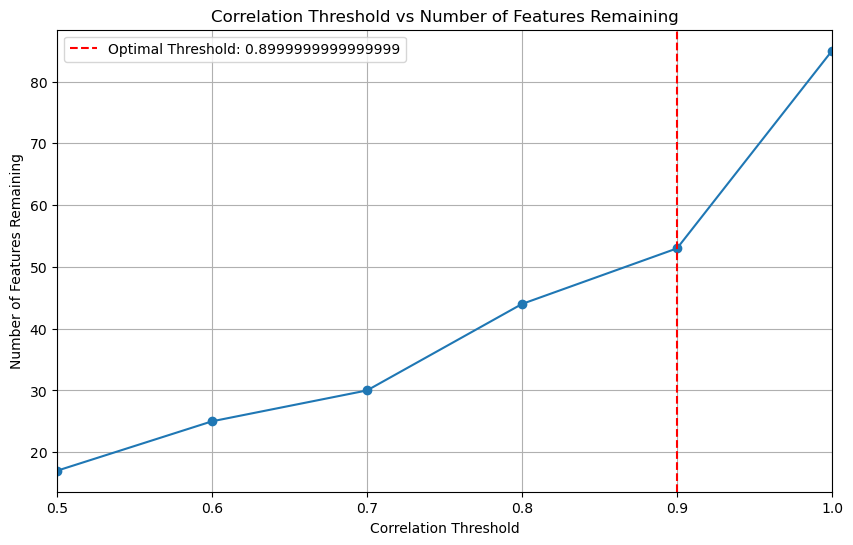

Optimal threshold: 0.8999999999999999
Number of features to retain at optimal threshold: 53


In [70]:
# a method to find the optimal correlation threshould value for feature reduction
def find_high_threshold_for_dimensionality_reduction(correlation, initial_threshold=0.50, final_threshold=1.00, step=0.1):
    thresholds = np.arange(initial_threshold, final_threshold + step, step)

    #intializing lists to store the thresholds and thier corresponding remaining features
    thresholds_list = []
    features_remaining_list = []

    for threshold in thresholds:
        upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
        
        # Identify columns to drop based on the threshold
        to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]
        
        # Calculate the number of features remaining after dropping
        num_features_remaining = len(correlation.columns) - len(to_drop)

        thresholds_list.append(threshold)
        features_remaining_list.append(num_features_remaining)
        
        print(f"Threshold: {threshold}, Features to drop: {len(to_drop)}, Features remaining: {num_features_remaining}")
    
    # Calculate the reduction in the number of features between consecutive thresholds
    reductions = np.diff(features_remaining_list)
    
    # Find the threshold with the highest reduction
    max_reduction_index = np.argmax(reductions)
    optimal_threshold = thresholds[max_reduction_index]  # Select the lower threshold in case of ties
    optimal_num_features = features_remaining_list[max_reduction_index]
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds_list, features_remaining_list, marker='o')
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold}')
    plt.xlabel('Correlation Threshold')
    plt.ylabel('Number of Features Remaining')
    plt.title('Correlation Threshold vs Number of Features Remaining')
    plt.legend()
    plt.grid(True)
    plt.xlim(initial_threshold, final_threshold)  
    #saving the image another analysis
    Corr_optimal_threshold_path = '../images/preprocessing/Corr_optimal_threshold.png'
    plt.savefig(Corr_optimal_threshold_path, dpi=600, bbox_inches='tight')
    plt.show()
    
    return optimal_threshold, optimal_num_features


# Calling the "find_high_threshold_for_dimensionality_reduction" method to get the optimal threshold value for dimensionality reduction
optimal_threshold, optimal_num_features = find_high_threshold_for_dimensionality_reduction(correlation)
print(f'Optimal threshold: {optimal_threshold}')
print(f'Number of features to retain at optimal threshold: {optimal_num_features}')

After getting an optimal threshold value which is "0.8999999999999999", I applied this threshold for feature reduction and obtained a dataframe only with 53 features.

In [71]:
# Remove Highly Correlated Features based on the "optimal threshold" value calculated above
threshold = optimal_threshold
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]
df_reduced_by_corr = df.drop(columns=to_drop)
print("Shape of dataset:", df.shape)
print("Shape of df_reduced:", df_reduced_by_corr.shape)

Shape of dataset: (121780, 85)
Shape of df_reduced: (121780, 53)


### Splitting Data into Features and Target

The dataframe df is splited before and after feature reduction using correlation. This allows for a comparison of the dataset with and without the reduction of features based on correlation.

In [75]:
#Spliting dataframe after feature reduction by correlation, the numberof features are reduced in to 53
 Split the DataFrame after feature reduction by correlation
X_corr_reduced = df_reduced_by_corr.drop('Pattern_Type', axis=1)
y = df_reduced_by_corr['Pattern_Type']
print("Shape of dataset:", df.shape)
print("Shape of X_corr_reduced:", X_corr_reduced.shape)

# Splitting the original dataframe before feature redution, with number of features are 85
X = df.drop('Pattern_Type', axis=1)
y = df['Pattern_Type']
print("Shape of X_features After outlier removal:", X.shape)
print("Shape of y_features After outlier removal:", X.shape)

Shape of dataset: (121780, 85)
Shape of X_corr_reduced: (121780, 52)
Shape of X_features After outlier removal: (121780, 84)
Shape of y_features After outlier removal: (121780, 84)


### Principal Component Analysis(PCA)
To apply PCA, we need to set a percentage of variance to retain. In this case, retaining 99% of the variance has been found to be optimal

Optimal threshold: 0.99
Number of components to retain 99.00% variance: 37


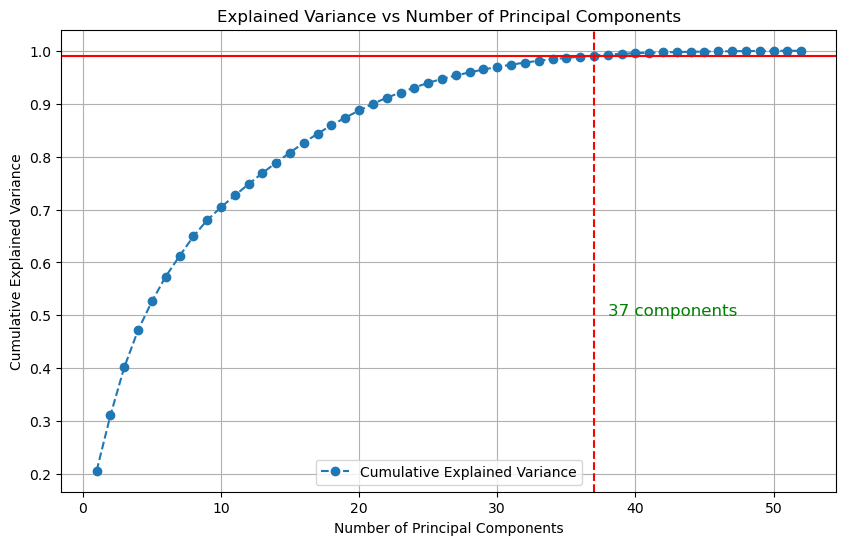

In [76]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr_reduced)

#Initializing PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Define a range of thresholds from 80% to 100% in increments of 1%
thresholds = np.arange(0.8, 1.01, 0.01)
optimal_threshold = 0.8
optimal_num_components = np.argmax(cumulative_explained_variance >= optimal_threshold) + 1

# Finding optimal threshold based on diminishing returns
# Loop through each threshold to find the one that retains the highest variance with the least components
for threshold in thresholds:
    num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
    if num_components > optimal_num_components:
        optimal_threshold = threshold
        optimal_num_components = num_components

print(f'Optimal threshold: {optimal_threshold:.2f}')
print(f'Number of components to retain {optimal_threshold*100:.2f}% variance: {optimal_num_components}')

# Plotting with optimal threshold
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.axhline(y=optimal_threshold, color='r', linestyle='-')
plt.axvline(x=optimal_num_components, color='r', linestyle='--')
plt.text(optimal_num_components + 1, 0.5, f'{optimal_num_components} components', color='green', fontsize=12)
plt.legend()
plt.grid()

# Save the plot as an image file
PCA_grah_path = '../images/preprocessing/PCA_grah.png'
plt.savefig(PCA_grah_path, dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

### Feature reduction based on Principal Component Analysis (PCA)
After calculating optimal threshold=0.99, which corresponds to retaining 99.00% of the variance with 37 components, I applied PCA for feature reduction by setting `n_components=0.99` to retain 99% of the variance.

In [78]:
# applying  PCA for feature reduction
pca = PCA(n_components=0.99)  # Retain 99% of the variance
X_pca = pca.fit_transform(X_scaled)

print("Shape of dataset:", df.shape)
print("Shape of X_corr_reduced:", X_corr_reduced.shape)
print("Shape of X_pca:", X_pca.shape)


Shape of dataset: (121780, 85)
Shape of X_corr_reduced: (121780, 52)
Shape of X_pca: (121780, 37)


### Splitting Dataset into Training and Test Sets

In [ ]:
# Split dataset into training and testing sets using Holdout method with 80% to 20%
# Split X and y (after outlier removal)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split X_corr_reduced and y (after reducing features using correlation threshold)
X_corr_train, X_corr_test, y_corr_train, y_corr_test = train_test_split(X_corr_reduced, y, test_size=0.2, random_state=42)

# Split X_pca and y (after reducing features using correlation threshold and PCA)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Check the split sizes
print("After outlier removal:")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("\n")
print("After feature removal using correlation threshold:")
print("Shape of X_corr_train:", X_corr_train.shape)
print("Shape of X_corr_test:", X_corr_test.shape)
print("Shape of y_corr_train:", y_corr_train.shape)
print("Shape of y_corr_test:", y_corr_test.shape) 
print("\n")
print("After feature removal using correlation threshold and PCA:")
print("Shape of X_pca_train:", X_pca_train.shape)
print("Shape of X_pca_test:", X_pca_test.shape)
print("Shape of y_pca_train:", y_pca_train.shape)
print("Shape of y_pca_test:", y_pca_test.shape)
print("\n")

# paths where the test sets should be stores  
X_test_path = '../dataset/X_test.csv'
y_test_path = '../dataset/y_test.csv'
X_corr_test_path = '../dataset/X_corr_test.csv'
y_corr_test_path = '../dataset/y_corr_test.csv'
X_pca_test_path = '../dataset/X_pca_test.csv'
y_pca_test_path = '../dataset/y_pca_test.csv'

# Convert to dataframe before saving 
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
X_corr_test_df = pd.DataFrame(X_corr_test)
y_corr_test_df = pd.DataFrame(y_corr_test)
X_pca_test_df = pd.DataFrame(X_pca_test)
y_pca_test_df = pd.DataFrame(y_pca_test)

#Saving the test sets for furhter usage
X_test_df.to_csv(X_test_path, index=False)
y_test_df.to_csv(y_test_path, index=False)
X_corr_test_df.to_csv(X_corr_test_path, index=False)
y_corr_test_df.to_csv(y_corr_test_path, index=False)
X_pca_test_df.to_csv(X_pca_test_path, index=False)
y_pca_test_df.to_csv(y_pca_test_path, index=False)



# Balancing Training Data using SMOTE

Balancing the data set by SMOTE, oversampling the minority class (0) to match the number of samples in class (1). This improves performance of classification models by enssuring that the model doesn't become biased towards the majority class (1).

I applied SMOTE to the traning sets from differente preprocessing stages:
1. To the training sets splited before any feature reduction is applied, with only outlier removal.
2. To the training sets splited after feature reduction using correlation.
3. To the training sets splited after feature reduction using correlation and PCA.

In [ ]:
# Applying SMOTE to balance the training set before any feature reduction is applied
sampler = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)

# Print the shape and class distribution for verification of SMOTE effectiveness
print("Shape of X_train_balanced:", X_train_balanced.shape)
print("Shape of y_train_balanced:", y_train_balanced.shape)
print("Class distribution before SMOTE:", y_train.value_counts().to_dict())
print("Class distribution after SMOTE:", pd.Series(y_train_balanced).value_counts().to_dict())

# Save the balanced datasets in to CVS files for later use
X_train_balanced_path = '../dataset/X_train_balanced.csv'
y_train_balanced_path = '../dataset/y_train_balanced.csv'

# Convert to DataFrame if necessary before saving
X_train_balanced_df = pd.DataFrame(X_train_balanced)
y_train_balanced_df = pd.DataFrame(y_train_balanced)

# Save to CSV
X_train_balanced_df.to_csv(X_train_balanced_path, index=False)
y_train_balanced_df.to_csv(y_train_balanced_path, index=False)

# Plotting the data before and after applying SMOTE to visualize the effect of balancing
plt.figure(figsize=(12, 6))

# Original data before SMOTE applied
plt.subplot(1, 2, 1)
plt.title("Before SMOTE")
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=25)

# Balanced data after SMOTE applied
plt.subplot(1, 2, 2)
plt.title("After SMOTE")
plt.scatter(X_train_balanced.iloc[:, 0], X_train_balanced.iloc[:, 1], c=y_train_balanced, cmap='viridis', edgecolor='k', s=25)

plt.tight_layout()
smote_after_outlier_path = '../images/preprocessing/smote_after_outlier.png'
plt.savefig(smote_after_outlier_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# Applying SMOTE to balance the training set after feature reduction by correlation 
sampler = SMOTE(random_state=42)
X_corr_train_balanced, y_corr_train_balanced = sampler.fit_resample(X_corr_train, y_corr_train)


# Save the balanced datasets
X_corr_train_balanced_path = '../dataset/X_corr_train_balanced.csv'
y_corr_train_balanced_path = '../dataset/y_corr_train_balanced.csv'

# Convert to DataFrame if necessary before saving
X_corr_train_balanced_df = pd.DataFrame(X_corr_train_balanced)
y_corr_train_balanced_df = pd.DataFrame(y_corr_train_balanced)

# Save to CSV
X_corr_train_balanced_df.to_csv(X_corr_train_balanced_path, index=False)
y_corr_train_balanced_df.to_csv(y_corr_train_balanced_path, index=False)

# Print the shape and class distribution for verification of SMOTE effectiveness
print("Shape of X_corr_train_balanced:", X_corr_train_balanced.shape)
print("Shape of y_corr_train_balanced:", y_corr_train_balanced.shape)
print("Class distribution before SMOTE:", y_corr_train.value_counts().to_dict())
print("Class distribution after SMOTE:", pd.Series(y_corr_train_balanced).value_counts().to_dict())

# Plotting the data before and after applying SMOTE to visualize the effect of balancing
plt.figure(figsize=(12, 6))

# Original data before SMOTE applied
plt.subplot(1, 2, 1)
plt.title("Before SMOTE")
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=25)

# Balanced data after SMOTE applied
plt.subplot(1, 2, 2)
plt.title("After SMOTE")
plt.scatter(X_train_balanced.iloc[:, 0], X_train_balanced.iloc[:, 1], c=y_train_balanced, cmap='viridis', edgecolor='k', s=25)

plt.tight_layout()
smote_after_correlation_path = '../images/preprocessing/smote_after_correlation.png'
plt.savefig(smote_after_correlation_path, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Applying SMOTE to balnce training set after feature reduction by correaltion and PCA
sampler = SMOTE(random_state=42)
X_pca_train_balanced, y_pca_train_balanced = sampler.fit_resample(X_pca_train, y_pca_train)

# Save the balanced datasets
X_pca_train_balanced_path = '../dataset/X_pca_train_balanced.csv'
y_pca_train_balanced_path = '../dataset/y_pca_train_balanced.csv'

# Convert to DataFrame if necessary before saving
X_pca_train_balanced_df = pd.DataFrame(X_pca_train_balanced)
y_pca_train_balanced_df = pd.DataFrame(y_pca_train_balanced)

# Save to CSV
X_pca_train_balanced_df.to_csv(X_pca_train_balanced_path, index=False)
y_pca_train_balanced_df.to_csv(y_pca_train_balanced_path, index=False)

# Print the shape and class distribution for verification of SMOTE effectiveness
print("Shape of X_pca_train_balanced:", X_pca_train_balanced.shape)
print("Shape of y_pca_train_balanced:", y_pca_train_balanced.shape)
print("Class distribution before SMOTE:", y_pca_train.value_counts().to_dict())
print("Class distribution after SMOTE:", pd.Series(y_pca_train_balanced).value_counts().to_dict())


# Plotting the data before and after applying SMOTE to visualize the effect of balancing
plt.figure(figsize=(12, 6))

# Original data before SMOTE applied
plt.subplot(1, 2, 1)
plt.title("Before SMOTE")
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_pca_train, cmap='viridis', edgecolor='k', s=25)

# Balanced data/ after SMOTE applied
plt.subplot(1, 2, 2)
plt.title("After SMOTE")
plt.scatter(X_pca_train_balanced[:, 0], X_pca_train_balanced[:, 1], c=y_pca_train_balanced, cmap='viridis', edgecolor='k', s=25)

plt.tight_layout()
smote_after_pca_path = '../images/preprocessing/SMOTE_after_PCA.png'
plt.savefig(smote_after_pca_path, dpi=600, bbox_inches='tight')
plt.show()



###  Navigation
- [Table of Contents](../Table_of_contents.ipynb)
- [Data Preparation and Exploration](../Data_exploration/Data_Exploration.ipynb)
- [Data Preprocessing](#2.-Data-Preprocessing)
- [Model Development](../conf/list_of_models.ipynb)
- [Model Selection and Performance Evaluation](../conf/list_of_performance_evaluations.ipynb)